In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import lognorm

In [4]:
stock = "TSLA"
ticker = yf.Ticker(stock)

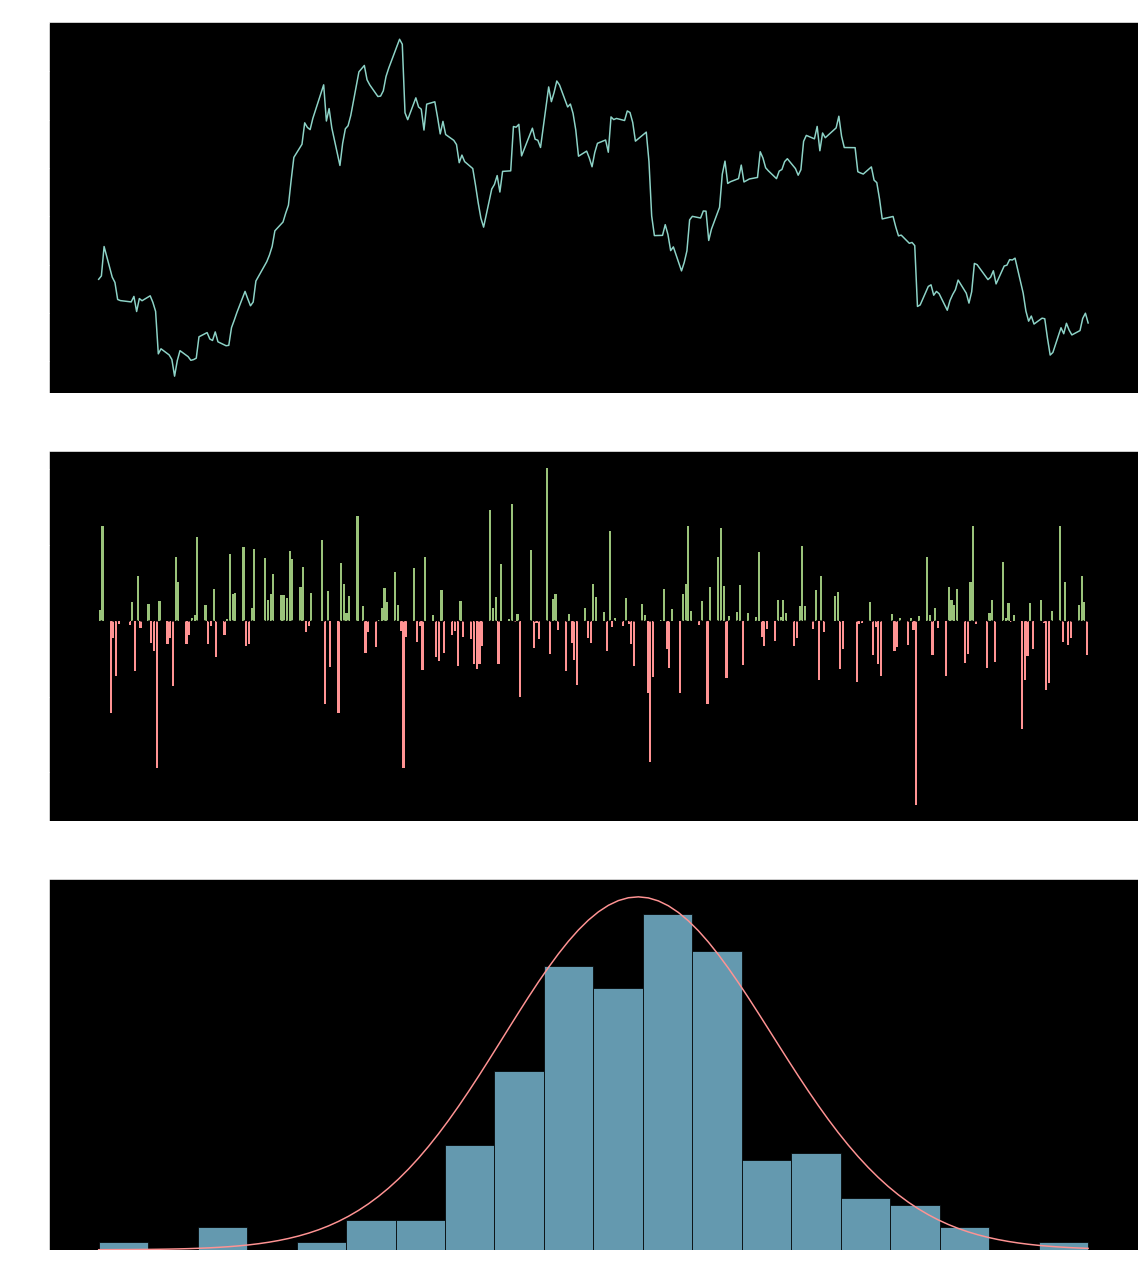

In [5]:
#change the background to black for matplotlib
plt.style.use('dark_background')

period = "1y"
data = ticker.history(period=period, interval="1d")
close = data['Close']
# change the x axis intervals to date time values of every fifth of the period
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 18))  # Create three subplots


#---------------------------------Plot the first graph as a line chart
ax1.plot(close)
ax1.set_ylabel("Close Price ($)")
ax1.set_title(f"{ticker.info['symbol']} Close Price Over {period} with End Price: {close[-1]:.2f}")


#---------------------------------Plot the second graph as a bar chart
percent_change = close.pct_change() * 100
ax2.bar(percent_change.index, percent_change, color=['#9AC37A' if x >= 0 else '#FF9393' for x in percent_change])
ax2.set_ylabel("Percent Change")
ax2.set_xlabel("Date")
ax2.set_title(f"{ticker.info['symbol']} Percent Change Over {period}")
ax2.axhline(y=0, color='black', linestyle='dotted')


#---------------------------------Plot the third graph as a histogram
ax3.hist(percent_change, bins=20, color='skyblue', edgecolor='black', density=True, alpha=0.75)
# plot the normal distribution of percent changes on top of the histogram

#---------- Create a log-normal distribution curve with the same mean and standard deviation as the percent change data
percent_change = percent_change.dropna() # Drop any NaN values

shape, loc, scale = lognorm.fit(percent_change)
x = np.linspace(percent_change.min(), percent_change.max(), 100)
pdf = lognorm.pdf(x, shape, loc, scale)

percent_change_mean = percent_change.mean()
percent_change_std = percent_change.std()

#---------- Adjust the maximum y-value of the curve to match the maximum y-value of the histogram
max_y_hist = max(ax3.get_ylim())
max_y_curve = max(pdf)
pdf_scaled = pdf * (max_y_hist / max_y_curve)

ax3.plot(x, pdf_scaled, color='#FF9393')
ax3.set_title(f"{ticker.info['symbol']} Percent Change Distribution Over {period} with Mean: {percent_change_mean:.2f} and Std: {percent_change_std:.2f}")
ax3.set_yticks([])  # Remove the y-ticks
ax3.set_xlabel("Percent Change")
ax3.set_ylabel("")


# upper_bound = percent_change_mean + 1 * percent_change_std
# lower_bound = percent_change_mean - 1 * percent_change_std
# # Add vertical lines at the upper and lower bounds
# ax3.axvline(x=upper_bound, color='red', linestyle='dashed')
# ax3.axvline(x=lower_bound, color='red', linestyle='dashed')


plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


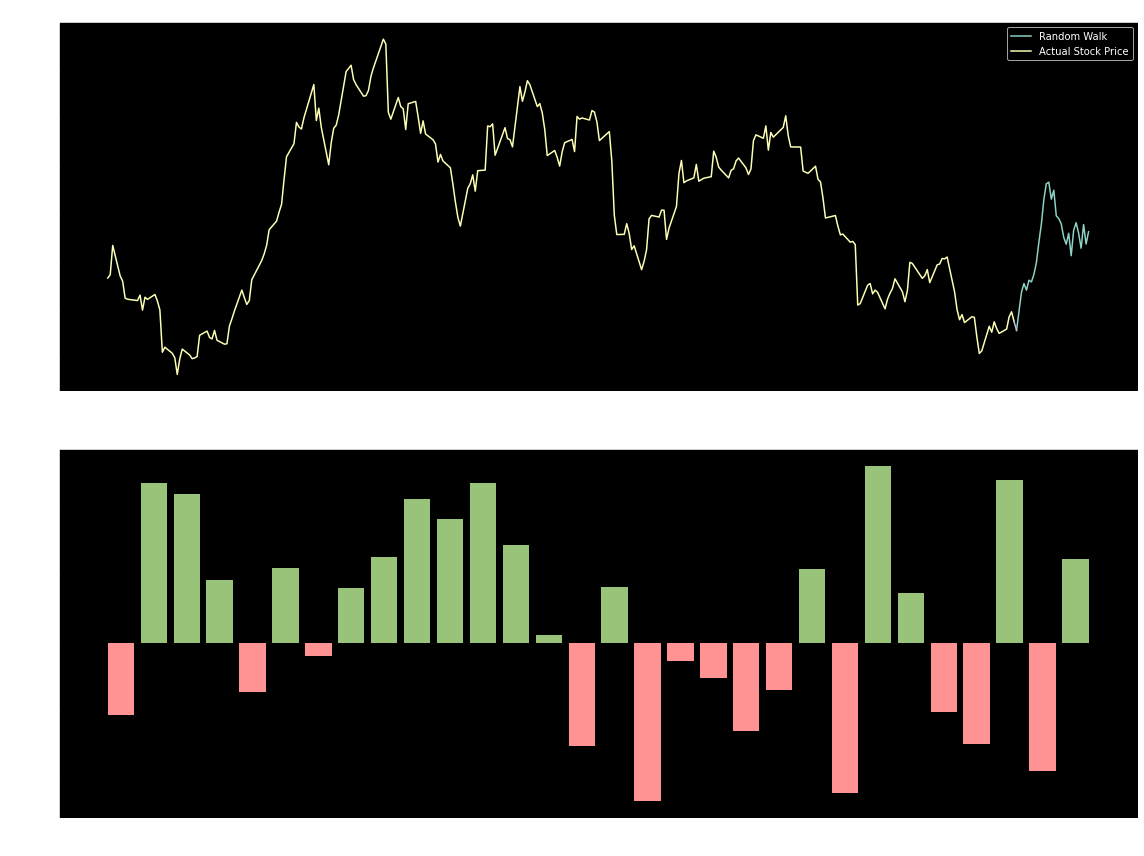

In [6]:
import datetime

# Set the number of days for the random walk

# Set the initial stock price
initial_price = close[-1]

# Generate random samples representing percent increases and decreases
percent_samples = np.random.normal(0, percent_change_std, num_days) / 100

# Clamp the percent samples to 2 standard deviations out
percent_samples = np.clip(percent_samples, -1.5 * percent_change_std, 1.5 * percent_change_std)

# Perform the random walk
walk = np.cumprod(1 + percent_samples) * initial_price

# Get the last date in the real data
last_date = close.index[-1]

# Generate the x-axis dates for the random walk
dates = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=num_days)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot the random walk with the updated x-axis in the first subplot
ax1.plot(dates, walk, label='Random Walk')
ax1.plot(close.index, close, label='Actual Stock Price')  # Plot the actual stock prices
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price ($)")
ax1.set_title("Random Walk of Stock Price")
ax1.legend()  # Show the legend

# Connect the two graphs
ax1.plot([close.index[-1], dates[0]], [close[-1], walk[0]])

# Plot the percent samples in the second subplot
ax2.bar(range(num_days), percent_samples, color=['#9AC37A' if x >= 0 else '#FF9393' for x in percent_samples])
ax2.set_xlabel("Day")
ax2.set_ylabel("Percent Sample")
ax2.set_title("Percent Samples")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


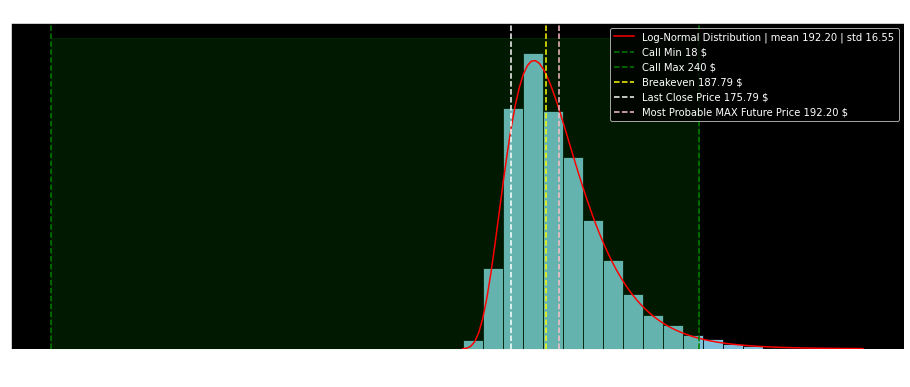

In [15]:
# Set the number of random walks
num_days = 21

call_price = 12
breakeven = close[-1] + call_price

num_walks = 10000

price_min = 18
price_max = 240

plt.subplots(figsize=(16, 6))

# Perform the random walks
max_values = []

for _ in range(num_walks):
    percent_samples = np.random.normal(percent_change_mean, percent_change_std, num_days) / 100
    walk = np.cumprod(1 + percent_samples) * initial_price
    max_value = np.max(walk)
    max_values.append(max_value)

# Create a histogram of the maximum values
plt.hist(max_values, bins=20, color='skyblue', edgecolor='black', density=True, alpha=0.75)

# Fit the log-normal distribution to the maximum values
shape, loc, scale = lognorm.fit(max_values)

# Generate the x-axis values for the log-normal distribution
x = np.linspace(np.min(max_values), np.max(max_values), 100)

# Calculate the probability density function (PDF) of the log-normal distribution
pdf = lognorm.pdf(x, shape, loc, scale)

# Plot the histogram of the maximum values
plt.hist(max_values, bins=20, color='skyblue', edgecolor='black', density=True, alpha=0.75)

# Plot the log-normal distribution on top of the histogram
plt.plot(x, pdf, color='red', label=f'Log-Normal Distribution | mean {np.mean(max_values):.2f} | std {np.std(max_values):.2f}')

plt.axvline(x=price_min, color='green', linestyle='dashed', label=f'Call Min {price_min} $')
plt.axvline(x=price_max, color='green', linestyle='dashed', label=f'Call Max {price_max} $')

plt.fill_betweenx([plt.ylim()[0], plt.ylim()[1]], price_min, price_max, color='green', alpha=0.2)

plt.axvline(x=breakeven, color='yellow', linestyle='dashed', label=f'Breakeven {breakeven:.2f} $')


plt.axvline(x=close[-1], color='white', linestyle='dashed', label=f'Last Close Price {close[-1]:.2f} $')

# find the probability of the stock price being above the breakeven price
probability_of_profit = 1 - lognorm.cdf(breakeven, shape, loc, scale)
# find the probability of the stock price being between the call min and call max
probability_in_spread = lognorm.cdf(price_max, shape, loc, scale) - lognorm.cdf(price_min, shape, loc, scale)

probability_price_min = 1- lognorm.cdf(price_min, shape, loc, scale)

# put a line at the most probable future price
most_probable = lognorm.mean(shape, loc, scale)
plt.axvline(x=most_probable, color='pink', linestyle='dashed', label=f'Most Probable MAX Future Price {most_probable:.2f} $')

# Add labels for probability and probability between
plt.xlabel("Maximum Value ($)")
plt.ylabel("")  # Remove the y-axis label
plt.title(f"Distribution of Maximum Values from {num_walks} Random Walks | Probability of Profit: {(probability_of_profit*100):.2f}% | Probability min: {probability_price_min*100:.2f}% | Probability in spread: {probability_in_spread*100:.2f}%")
plt.legend()
plt.gca().set_yticks([])  # Re

plt.show()

